In [1]:
from test import test_loop

from data_loading import get_image_data_loader
from models import *
from train import training_loop
from utils import accuracy

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

### Params

In [ ]:
batch_size = 128
learning_rate = 1e-1
momentum = 0.9
n_epochs = 5
dataset_name = "mnist"
dataset_to_n_classes = {
    "mnist": 10,
    "cifar10": 10,
    "fmnist": 10,
}
exp_name = "mlp-mnist"
use_cuda = False
device = "gpu" if torch.cuda.is_available() and use_cuda else "cpu"
device

### Data loading

In [11]:
train_data, eval_data = get_image_data_loader(
    dataset_name,
    train=True,
    val_share=0.1,
    shuffle=True,
    batch_size=batch_size,
    single_batch=False,
)

Dataset lengths: train-54000, val-6000


In [12]:
(a, b) = next(iter(train_data))
print(a.shape, b.shape)
input_dim = np.prod(a.shape[1:])
output_dim = dataset_to_n_classes[dataset_name]

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [13]:
n_hidden = 5
hidden_size = 256
mlp_dims = [input_dim] + [hidden_size for _ in range(n_hidden)] + [output_dim]
mlp = MLP(mlp_dims)

In [14]:
# ImageNet version
# resnet_imagenet = Resnet(
# img_channels=3,
# n_classes=10,
# extra_blocks_per_layer=[1, 3, 5, 2,],
# resnet_channels=[64, 128, 256, 512],
# stem_channels=64,
# stem_downsample=True,
# )
# Cifar10 version
# resnet_cifar = Resnet(
#     img_channels=3,
#     n_classes=10,
#     extra_blocks_per_layer=[5, 5, 5],
#     resnet_channels=[16, 32, 64],
#     stem_channels=16,
#     stem_downsample=False,
# )
# summary(resnet_cifar, (3, 32, 32))
baby_resnet = Resnet(
    img_channels=3,
    n_classes=10,
    extra_blocks_per_layer=[1, 1, 1],
    resnet_channels=[16, 32, 64],
    stem_channels=16,
    stem_downsample=False,
)

### Optimizer and model selection

In [15]:
model = mlp
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[32000, 48000,], gamma=0.1,
)

### Training

In [16]:
training_loop(
    name=exp_name,
    model=model,
    opt=optimizer,
    scheduler=scheduler,
    train_loader=train_data,
    eval_loader=eval_data,
    loss_fn=F.cross_entropy,
    metric_fn=accuracy,
    n_epochs=n_epochs,
    device=device,
    print_every=100,
    write_every=100,
    check_every=100,
)

Step: 100 | Training Loss: 1.78911
Step: 100 | Training Metric: 0.28906
Step: 200 | Training Loss: 0.61613
Step: 200 | Training Metric: 0.78906
Step: 300 | Training Loss: 0.36819
Step: 300 | Training Metric: 0.89844
Step: 400 | Training Loss: 0.33749
Step: 400 | Training Metric: 0.90625
Step: 500 | Training Loss: 0.21975
Step: 500 | Training Metric: 0.95312
Step: 600 | Training Loss: 0.12535
Step: 600 | Training Metric: 0.95312
Step: 700 | Training Loss: 0.22960
Step: 700 | Training Metric: 0.93750
Step: 800 | Training Loss: 0.07459
Step: 800 | Training Metric: 0.97656
Step: 900 | Training Loss: 0.05047
Step: 900 | Training Metric: 0.97656
Step: 1000 | Training Loss: 0.13690
Step: 1000 | Training Metric: 0.96875
Step: 1100 | Training Loss: 0.03915
Step: 1100 | Training Metric: 0.98438
Step: 1200 | Training Loss: 0.11316
Step: 1200 | Training Metric: 0.96875
Step: 100 | Validation Loss: 0.12783
Step: 100 | Validation Metric: 0.96094
Step: 1300 | Training Loss: 0.06092
Step: 1300 | Train

KeyboardInterrupt: 

### Load from checkpoint

In [17]:
loaded = torch.load(
    os.path.join(os.path.join("data", "checkpoints"), "mlp-mnist-2900.pt"),
    map_location=device,
)
model.load_state_dict(loaded["model_state"])

<All keys matched successfully>

### Load test data

In [20]:
test_loader, should_be_none = get_image_data_loader(
    dataset_name,
    train=False,
    val_share=0.1,
    shuffle=True,
    batch_size=10,
    single_batch=False,
)
assert should_be_none is None

Dataset lengths: train-10000, val-0


### Evaluated the loaded model

Testing completed, Metric: 0.97230, Loss: 0.10392
Grid generated with labels: [7 3 1 5 0 6 2 0 3 3]
Corresponding predictions: [7 3 1 5 0 6 3 0 3 3]


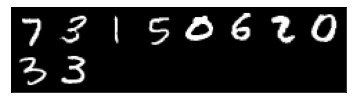

In [21]:
test_loop(
    test_loader=test_loader,
    model=model,
    device=device,
    metric_fn=accuracy,
    plot=True,
    loss_fn=F.cross_entropy,
)